In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score


In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# Generate realistic dataset
def generate_powergrid_dataset(num_projects=200, months=24):
    np.random.seed(42)
    
    # Base data
    states = ['Tamil Nadu', 'Gujarat', 'Assam', 'Rajasthan', 'Maharashtra', 
              'Karnataka', 'Uttar Pradesh', 'West Bengal', 'Odisha', 'Andhra Pradesh']
    
    tower_types = ['Type-A', 'Type-B', 'Type-C', 'Type-D']
    substation_types = ['132kV', '220kV', '400kV', '765kV']
    
    projects = []
    
    for project_id in range(num_projects):
        project_id_str = f"P{project_id+1:03d}"
        state = np.random.choice(states)
        tower_type = np.random.choice(tower_types)
        substation_type = np.random.choice(substation_types)
        
        # Realistic budget based on tower and substation types
        base_budget = {
            'Type-A': 60, 'Type-B': 75, 'Type-C': 90, 'Type-D': 110
        }[tower_type] * {
            '132kV': 0.8, '220kV': 1.0, '400kV': 1.3, '765kV': 1.6
        }[substation_type]
        
        budget = base_budget + np.random.normal(0, 10)
        budget = max(40, min(200, budget))  # Reasonable range
        
        # Geographic risk based on state (mountainous/remote areas have higher risk)
        high_risk_states = ['Assam', 'Himachal Pradesh', 'Uttarakhand', 'Jammu & Kashmir']
        medium_risk_states = ['Rajasthan', 'Odisha', 'West Bengal']
        
        if state in high_risk_states:
            geographic_risk = np.random.randint(7, 10)
        elif state in medium_risk_states:
            geographic_risk = np.random.randint(5, 8)
        else:
            geographic_risk = np.random.randint(3, 7)
        
        # Tax rate variation
        tax_rates = [5, 12, 18, 28]
        tax_rate = np.random.choice(tax_rates, p=[0.1, 0.3, 0.5, 0.1])
        
        # Generate monthly data for 2 years
        for month in range(1, months + 1):
            year = 2023 if month <= 12 else 2024
            actual_month = month if month <= 12 else month - 12
            
            # Base demand based on project characteristics
            base_demand = budget * 15  # Base multiplier
            
            # Tower type multiplier
            tower_multiplier = {
                'Type-A': 1.0, 'Type-B': 1.2, 'Type-C': 1.5, 'Type-D': 1.8
            }[tower_type]
            
            # Substation multiplier
            substation_multiplier = {
                '132kV': 0.8, '220kV': 1.0, '400kV': 1.4, '765kV': 1.8
            }[substation_type]
            
            # Geographic risk multiplier (higher risk = more materials for contingencies)
            risk_multiplier = 1 + (geographic_risk * 0.05)
            
            # Seasonal variation (monsoon season affects construction)
            seasonal_multiplier = 1.0
            if actual_month in [6, 7, 8]:  # Monsoon months
                seasonal_multiplier = 0.7  # Reduced work
            elif actual_month in [1, 2, 3]:  # Peak construction
                seasonal_multiplier = 1.2
            
            # Project phase multiplier (start slow, peak, then slow down)
            if month <= 3:  # Initial phase
                phase_multiplier = 0.6
            elif month <= 15:  # Peak construction
                phase_multiplier = 1.2
            else:  # Final phase
                phase_multiplier = 0.8
            
            # Calculate final demand with some random noise
            demand = (base_demand * tower_multiplier * substation_multiplier * 
                     risk_multiplier * seasonal_multiplier * phase_multiplier)
            demand += np.random.normal(0, demand * 0.1)  # 10% noise
            demand = max(500, min(3000, demand))  # Reasonable range
            
            projects.append({
                'Project_ID': project_id_str,
                'Project_Name': f"{state.replace(' ', '')}_{substation_type}_Project",
                'State': state,
                'Tower_Type': tower_type,
                'Substation_Type': substation_type,
                'Budget_Cr': round(budget, 2),
                'Tax_Rate': tax_rate,
                'Month': actual_month,
                'Geographic_Risk': geographic_risk,
                'Material_Demand_Tons': round(demand, 2),
                'Year': year
            })
    
    return pd.DataFrame(projects)

# Generate and save dataset
print("📊 Generating POWERGRID Dataset...")
df = generate_powergrid_dataset()
df.to_csv('powergrid_demand_forecast_dataset.csv', index=False)
print(f"✅ Dataset created with {len(df)} rows")
print(df.head())

📊 Generating POWERGRID Dataset...
✅ Dataset created with 4800 rows
  Project_ID                Project_Name          State Tower_Type  \
0       P001  UttarPradesh_132kV_Project  Uttar Pradesh     Type-D   
1       P001  UttarPradesh_132kV_Project  Uttar Pradesh     Type-D   
2       P001  UttarPradesh_132kV_Project  Uttar Pradesh     Type-D   
3       P001  UttarPradesh_132kV_Project  Uttar Pradesh     Type-D   
4       P001  UttarPradesh_132kV_Project  Uttar Pradesh     Type-D   

  Substation_Type  Budget_Cr  Tax_Rate  Month  Geographic_Risk  \
0           132kV      93.44        12      1                3   
1           132kV      93.44        12      2                3   
2           132kV      93.44        12      3                3   
3           132kV      93.44        12      4                3   
4           132kV      93.44        12      5                3   

   Material_Demand_Tons  Year  
0               1568.26  2023  
1               1717.74  2023  
2               183

In [9]:
# Exploratory Data Analysis
def explore_dataset(df):
    print("🔍 Dataset Overview:")
    print(f"Shape: {df.shape}")
    print(f"\n📋 Columns: {df.columns.tolist()}")
    print(f"\n📊 Data Types:\n{df.dtypes}")
    print(f"\n❓ Missing Values:\n{df.isnull().sum()}")
    print(f"\n📈 Basic Statistics:\n{df.describe()}")
    
    # Unique values for categorical columns
    print(f"\n🏢 Unique Projects: {df['Project_ID'].nunique()}")
    print(f"🏞️ States: {df['State'].nunique()}")
    print(f"🗼 Tower Types: {df['Tower_Type'].unique()}")
    print(f"⚡ Substation Types: {df['Substation_Type'].unique()}")

explore_dataset(df)

🔍 Dataset Overview:
Shape: (4800, 11)

📋 Columns: ['Project_ID', 'Project_Name', 'State', 'Tower_Type', 'Substation_Type', 'Budget_Cr', 'Tax_Rate', 'Month', 'Geographic_Risk', 'Material_Demand_Tons', 'Year']

📊 Data Types:
Project_ID               object
Project_Name             object
State                    object
Tower_Type               object
Substation_Type          object
Budget_Cr               float64
Tax_Rate                  int32
Month                     int64
Geographic_Risk           int64
Material_Demand_Tons    float64
Year                      int64
dtype: object

❓ Missing Values:
Project_ID              0
Project_Name            0
State                   0
Tower_Type              0
Substation_Type         0
Budget_Cr               0
Tax_Rate                0
Month                   0
Geographic_Risk         0
Material_Demand_Tons    0
Year                    0
dtype: int64

📈 Basic Statistics:
         Budget_Cr     Tax_Rate        Month  Geographic_Risk  \
count  

In [1]:
!pip install xgboost

  Using cached xgboost-3.0.5-py3-none-win_amd64.whl.metadata (2.1 kB)
   ---------------------------------------- 0.0/56.8 MB ? eta -:--:--
   ---------------------------------------- 0.0/56.8 MB ? eta -:--:--
   ---------------------------------------- 0.0/56.8 MB 653.6 kB/s eta 0:01:27
   ---------------------------------------- 0.1/56.8 MB 975.2 kB/s eta 0:00:59
   ---------------------------------------- 0.2/56.8 MB 1.0 MB/s eta 0:00:56
   ---------------------------------------- 0.2/56.8 MB 1.3 MB/s eta 0:00:44
   ---------------------------------------- 0.3/56.8 MB 1.4 MB/s eta 0:00:41
   ---------------------------------------- 0.4/56.8 MB 1.6 MB/s eta 0:00:36
   ---------------------------------------- 0.5/56.8 MB 1.7 MB/s eta 0:00:34
   ---------------------------------------- 0.6/56.8 MB 1.8 MB/s eta 0:00:32
   ---------------------------------------- 0.7/56.8 MB 1.8 MB/s eta 0:00:32
    --------------------------------------- 0.8/56.8 MB 1.9 MB/s eta 0:00:30
    ------------

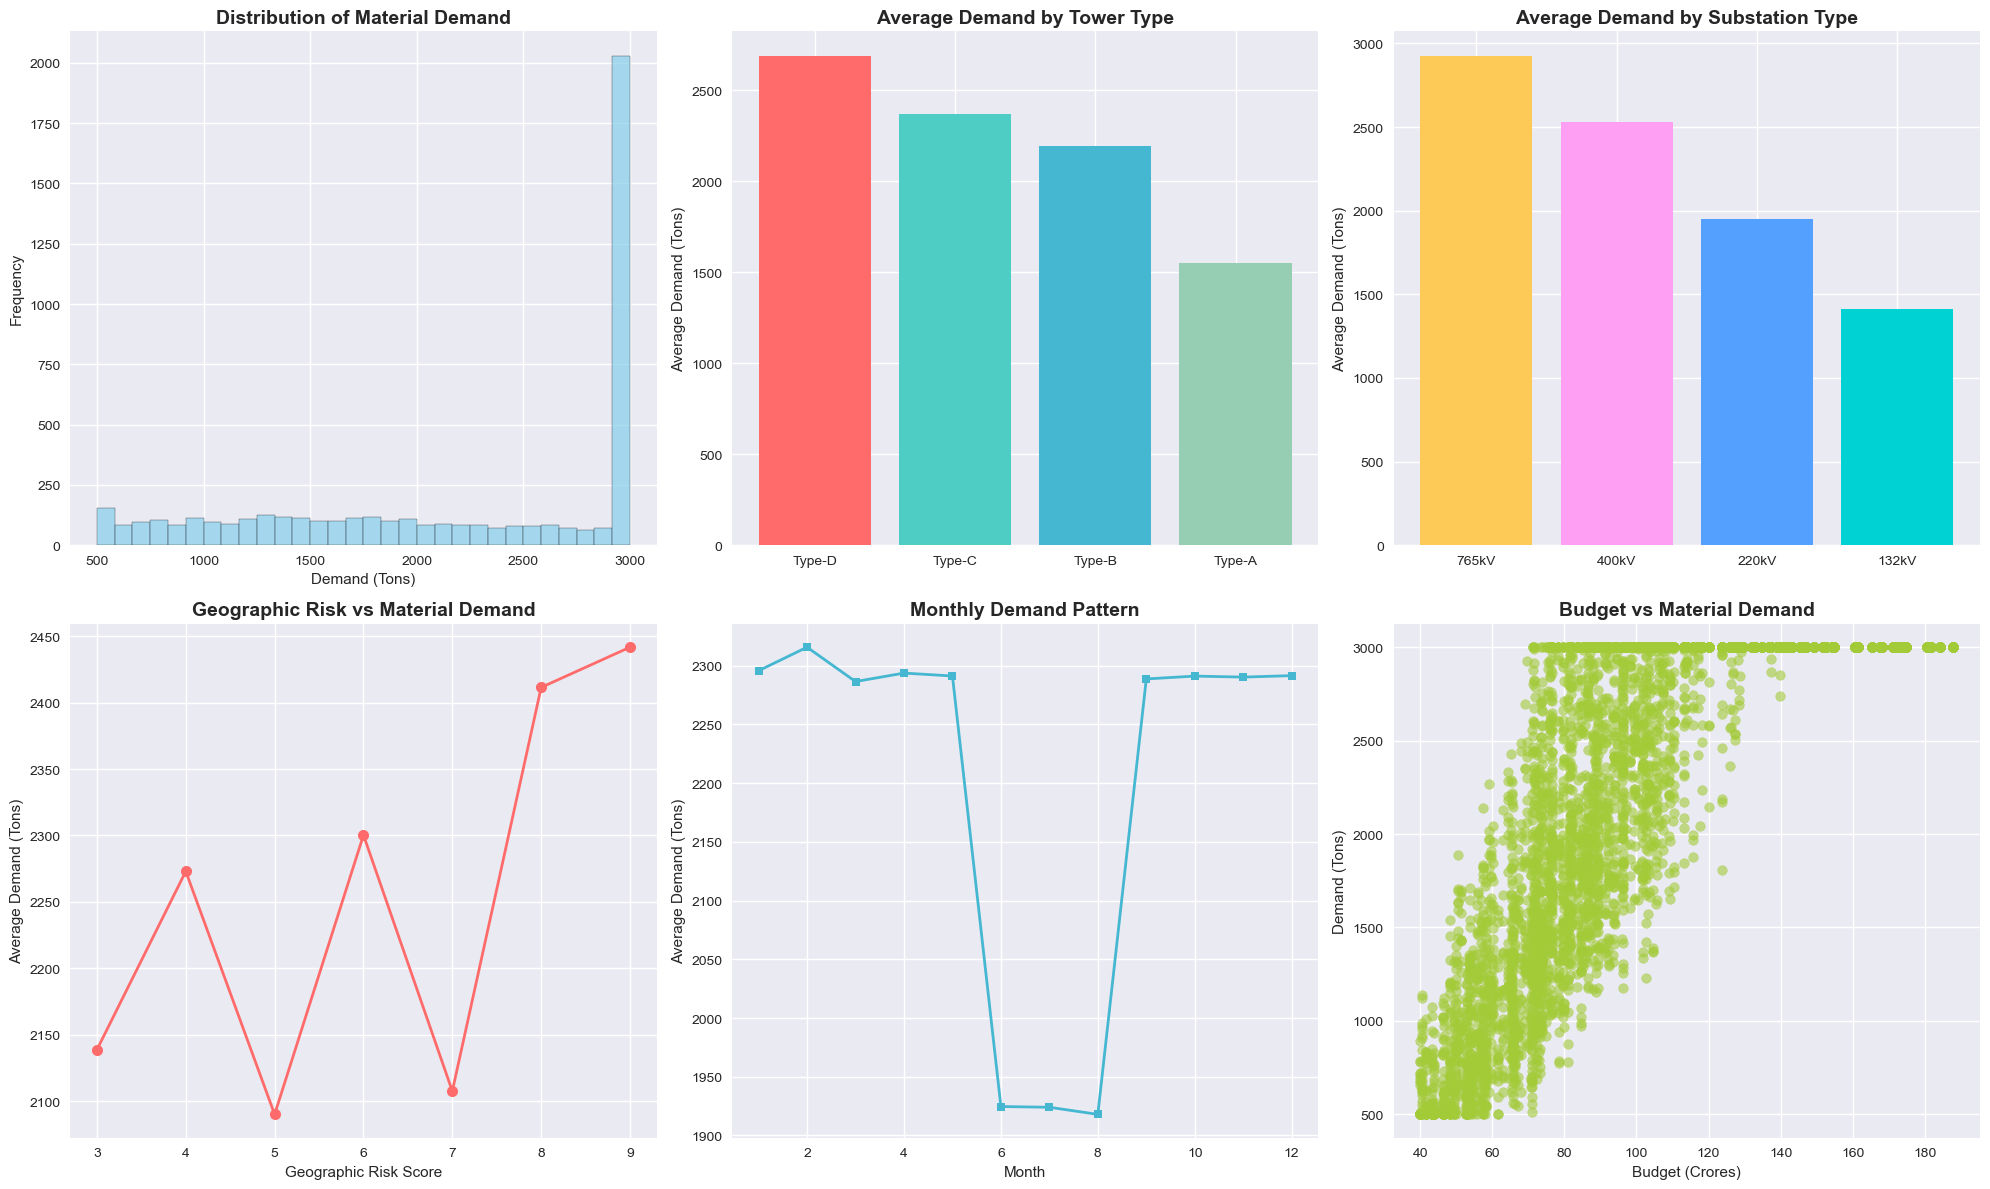

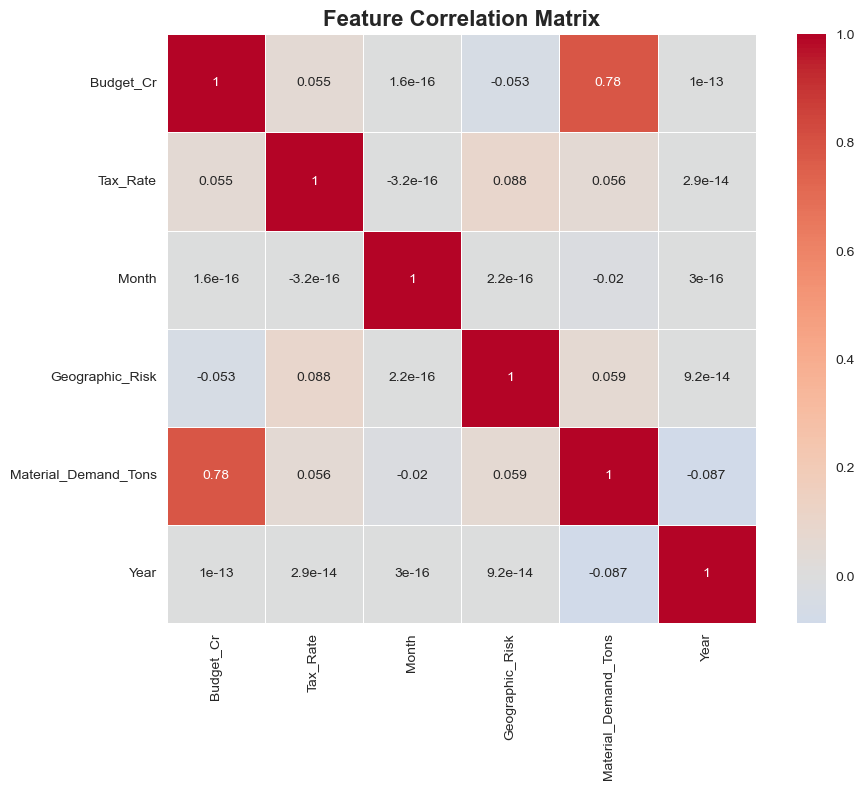

In [11]:
# Enhanced Visualizations
plt.style.use('seaborn-v0_8')
fig, axes = plt.subplots(2, 3, figsize=(20, 12))

# 1. Demand distribution
axes[0,0].hist(df['Material_Demand_Tons'], bins=30, alpha=0.7, color='skyblue', edgecolor='black')
axes[0,0].set_title('Distribution of Material Demand', fontsize=14, fontweight='bold')
axes[0,0].set_xlabel('Demand (Tons)')
axes[0,0].set_ylabel('Frequency')

# 2. Demand by Tower Type
tower_demand = df.groupby('Tower_Type')['Material_Demand_Tons'].mean().sort_values(ascending=False)
axes[0,1].bar(tower_demand.index, tower_demand.values, color=['#FF6B6B', '#4ECDC4', '#45B7D1', '#96CEB4'])
axes[0,1].set_title('Average Demand by Tower Type', fontsize=14, fontweight='bold')
axes[0,1].set_ylabel('Average Demand (Tons)')

# 3. Demand by Substation Type
substation_demand = df.groupby('Substation_Type')['Material_Demand_Tons'].mean().sort_values(ascending=False)
axes[0,2].bar(substation_demand.index, substation_demand.values, color=['#FECA57', '#FF9FF3', '#54A0FF', '#00D2D3'])
axes[0,2].set_title('Average Demand by Substation Type', fontsize=14, fontweight='bold')
axes[0,2].set_ylabel('Average Demand (Tons)')

# 4. Geographic Risk vs Demand
risk_demand = df.groupby('Geographic_Risk')['Material_Demand_Tons'].mean()
axes[1,0].plot(risk_demand.index, risk_demand.values, marker='o', linewidth=2, markersize=8, color='#FF6B6B')
axes[1,0].set_title('Geographic Risk vs Material Demand', fontsize=14, fontweight='bold')
axes[1,0].set_xlabel('Geographic Risk Score')
axes[1,0].set_ylabel('Average Demand (Tons)')

# 5. Monthly Demand Pattern
monthly_demand = df.groupby('Month')['Material_Demand_Tons'].mean()
axes[1,1].plot(monthly_demand.index, monthly_demand.values, marker='s', linewidth=2, markersize=6, color='#45B7D1')
axes[1,1].set_title('Monthly Demand Pattern', fontsize=14, fontweight='bold')
axes[1,1].set_xlabel('Month')
axes[1,1].set_ylabel('Average Demand (Tons)')

# 6. Budget vs Demand scatter
axes[1,2].scatter(df['Budget_Cr'], df['Material_Demand_Tons'], alpha=0.6, color='#A3CB38')
axes[1,2].set_title('Budget vs Material Demand', fontsize=14, fontweight='bold')
axes[1,2].set_xlabel('Budget (Crores)')
axes[1,2].set_ylabel('Demand (Tons)')

plt.tight_layout()
plt.show()

# Correlation heatmap
plt.figure(figsize=(10, 8))
numeric_df = df.select_dtypes(include=[np.number])
correlation_matrix = numeric_df.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0, 
            square=True, linewidths=0.5)
plt.title('Feature Correlation Matrix', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

In [13]:
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split

def prepare_features(df):
    # Create a copy of the dataframe
    df_processed = df.copy()
    
    # Feature Engineering
    df_processed['Month_Sin'] = np.sin(2 * np.pi * df_processed['Month'] / 12)
    df_processed['Month_Cos'] = np.cos(2 * np.pi * df_processed['Month'] / 12)
    
    # Budget to Demand ratio
    df_processed['Budget_Demand_Ratio'] = df_processed['Budget_Cr'] / df_processed['Material_Demand_Tons']
    
    # Risk adjusted budget
    df_processed['Risk_Adjusted_Budget'] = df_processed['Budget_Cr'] * (1 + df_processed['Geographic_Risk'] / 10)
    
    # Encode categorical variables
    label_encoders = {}
    categorical_columns = ['State', 'Tower_Type', 'Substation_Type']
    
    for col in categorical_columns:
        le = LabelEncoder()
        df_processed[col + '_Encoded'] = le.fit_transform(df_processed[col])
        label_encoders[col] = le
    
    # Select features for modeling
    feature_columns = [
        'Budget_Cr', 'Tax_Rate', 'Geographic_Risk', 'Month_Sin', 'Month_Cos',
        'Budget_Demand_Ratio', 'Risk_Adjusted_Budget',
        'State_Encoded', 'Tower_Type_Encoded', 'Substation_Type_Encoded'
    ]
    
    X = df_processed[feature_columns]
    y = df_processed['Material_Demand_Tons']
    
    return X, y, df_processed, label_encoders

print("🔧 Preparing Features...")
X, y, df_processed, label_encoders = prepare_features(df)
print(f"✅ Features prepared: {X.shape[1]} features")

🔧 Preparing Features...
✅ Features prepared: 10 features


In [15]:
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import cross_val_score
import xgboost as xgb

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("🤖 Training Multiple Models...")

# Initialize models
models = {
    'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42),
    'XGBoost': xgb.XGBRegressor(n_estimators=100, random_state=42),
    'Gradient Boosting': GradientBoostingRegressor(n_estimators=100, random_state=42),
    'Ridge Regression': Ridge(alpha=1.0)
}

# Train and evaluate models
results = {}
feature_importance_df = pd.DataFrame()

for name, model in models.items():
    print(f"Training {name}...")
    
    # Train model
    model.fit(X_train, y_train)
    
    # Predictions
    y_pred = model.predict(X_test)
    
    # Calculate metrics
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)
    
    # Cross-validation
    cv_scores = cross_val_score(model, X, y, cv=5, scoring='r2')
    
    results[name] = {
        'MAE': mae,
        'RMSE': rmse,
        'R2_Score': r2,
        'CV_R2_Mean': cv_scores.mean(),
        'CV_R2_Std': cv_scores.std(),
        'model': model
    }
    
    # Feature importance for tree-based models
    if hasattr(model, 'feature_importances_'):
        importance_df = pd.DataFrame({
            'feature': X.columns,
            'importance': model.feature_importances_,
            'model': name
        })
        feature_importance_df = pd.concat([feature_importance_df, importance_df], ignore_index=True)
    
    print(f"✅ {name} - R²: {r2:.4f}, RMSE: {rmse:.2f}")

# Display results
results_df = pd.DataFrame(results).T
results_df = results_df.drop('model', axis=1)
print("\n📊 Model Comparison:")
print(results_df.round(4))

🤖 Training Multiple Models...
Training Random Forest...
✅ Random Forest - R²: 0.9994, RMSE: 21.57
Training XGBoost...
✅ XGBoost - R²: 0.9992, RMSE: 24.72
Training Gradient Boosting...
✅ Gradient Boosting - R²: 0.9964, RMSE: 51.76
Training Ridge Regression...
✅ Ridge Regression - R²: 0.8573, RMSE: 326.94

📊 Model Comparison:
                          MAE        RMSE  R2_Score CV_R2_Mean CV_R2_Std
Random Forest        9.854239   21.571451  0.999379   0.992372  0.011804
XGBoost             13.506546   24.716726  0.999185   0.987314  0.021429
Gradient Boosting   34.296472   51.758884  0.996424   0.991038   0.00605
Ridge Regression   273.653194  326.936183  0.857322     0.8349  0.029635


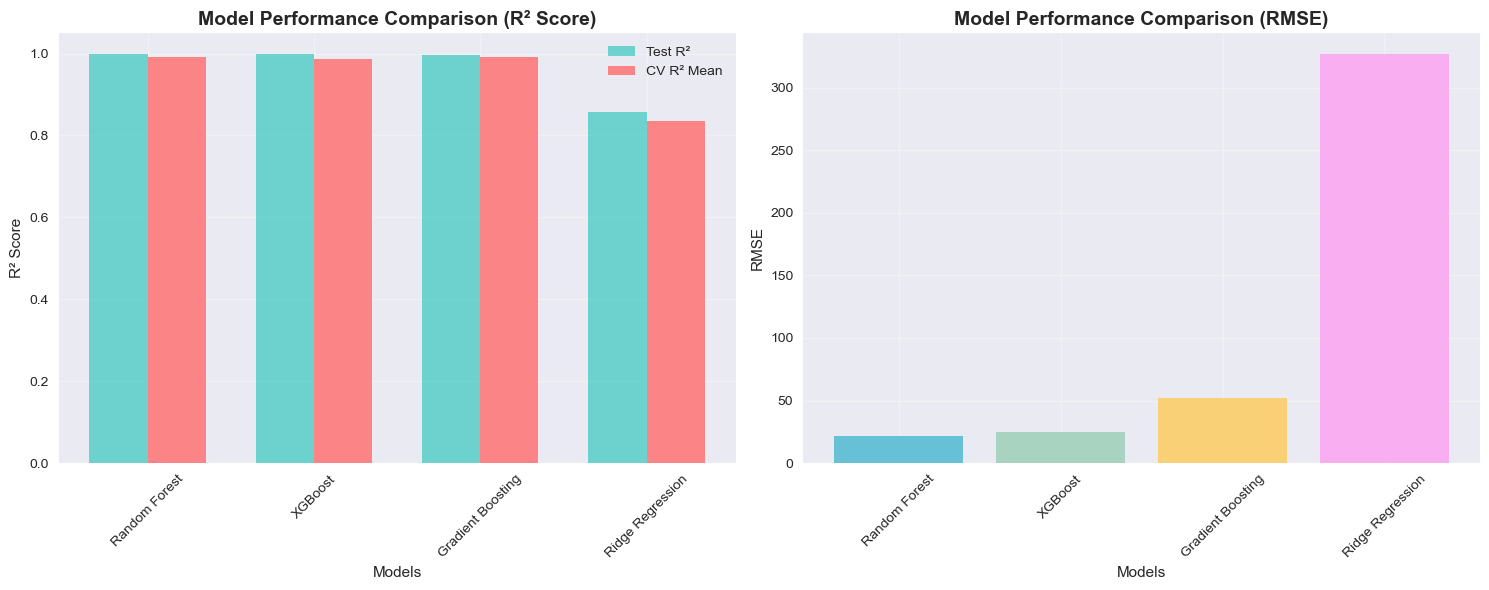

<Figure size 1200x800 with 0 Axes>

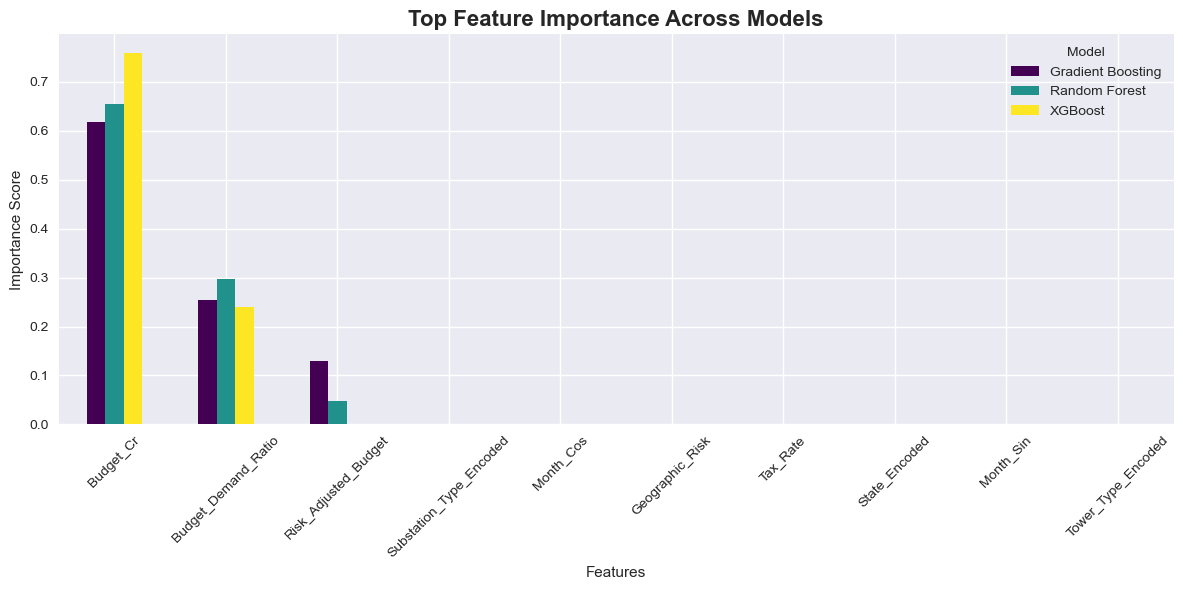

In [17]:
# Model performance comparison
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# R² Score comparison
models_list = list(results.keys())
r2_scores = [results[model]['R2_Score'] for model in models_list]
cv_r2_scores = [results[model]['CV_R2_Mean'] for model in models_list]

x = np.arange(len(models_list))
width = 0.35

axes[0].bar(x - width/2, r2_scores, width, label='Test R²', alpha=0.8, color='#4ECDC4')
axes[0].bar(x + width/2, cv_r2_scores, width, label='CV R² Mean', alpha=0.8, color='#FF6B6B')
axes[0].set_xlabel('Models')
axes[0].set_ylabel('R² Score')
axes[0].set_title('Model Performance Comparison (R² Score)', fontsize=14, fontweight='bold')
axes[0].set_xticks(x)
axes[0].set_xticklabels(models_list, rotation=45)
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# RMSE Comparison
rmse_scores = [results[model]['RMSE'] for model in models_list]
axes[1].bar(models_list, rmse_scores, alpha=0.8, color=['#45B7D1', '#96CEB4', '#FECA57', '#FF9FF3'])
axes[1].set_xlabel('Models')
axes[1].set_ylabel('RMSE')
axes[1].set_title('Model Performance Comparison (RMSE)', fontsize=14, fontweight='bold')
axes[1].tick_params(axis='x', rotation=45)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Feature Importance
if not feature_importance_df.empty:
    plt.figure(figsize=(12, 8))
    
    # Get top features across all models
    top_features = (feature_importance_df.groupby('feature')['importance']
                   .mean().nlargest(10).index)
    
    filtered_importance = feature_importance_df[feature_importance_df['feature'].isin(top_features)]
    
    # Pivot for grouped bar chart
    pivot_df = filtered_importance.pivot(index='feature', columns='model', values='importance')
    pivot_df = pivot_df.loc[top_features]  # Sort by importance
    
    ax = pivot_df.plot(kind='bar', figsize=(12, 6), colormap='viridis')
    plt.title('Top Feature Importance Across Models', fontsize=16, fontweight='bold')
    plt.xlabel('Features')
    plt.ylabel('Importance Score')
    plt.xticks(rotation=45)
    plt.legend(title='Model')
    plt.tight_layout()
    plt.show()

🏆 Best Model: Random Forest
📈 Best R² Score: 0.9994


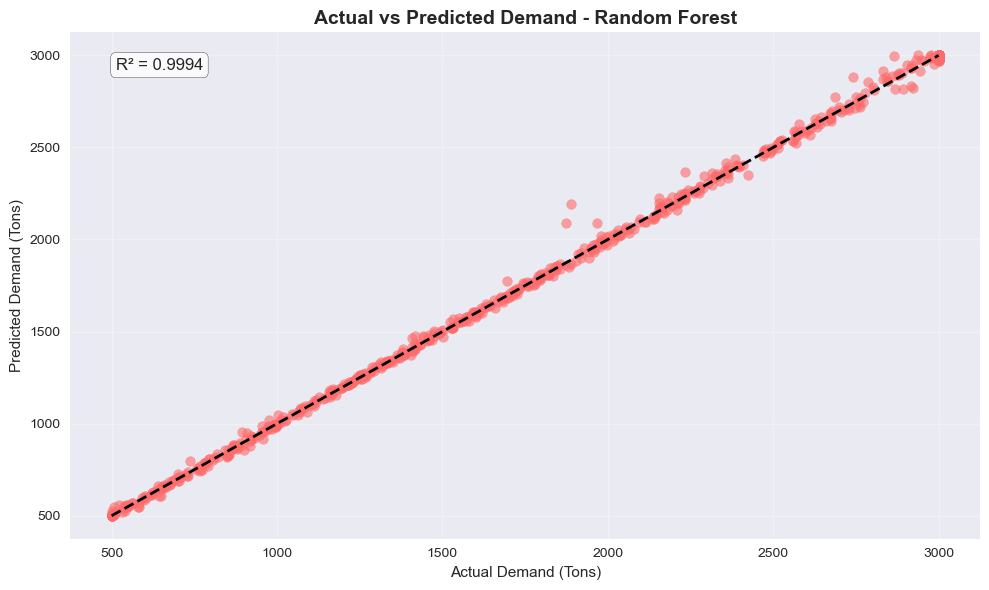

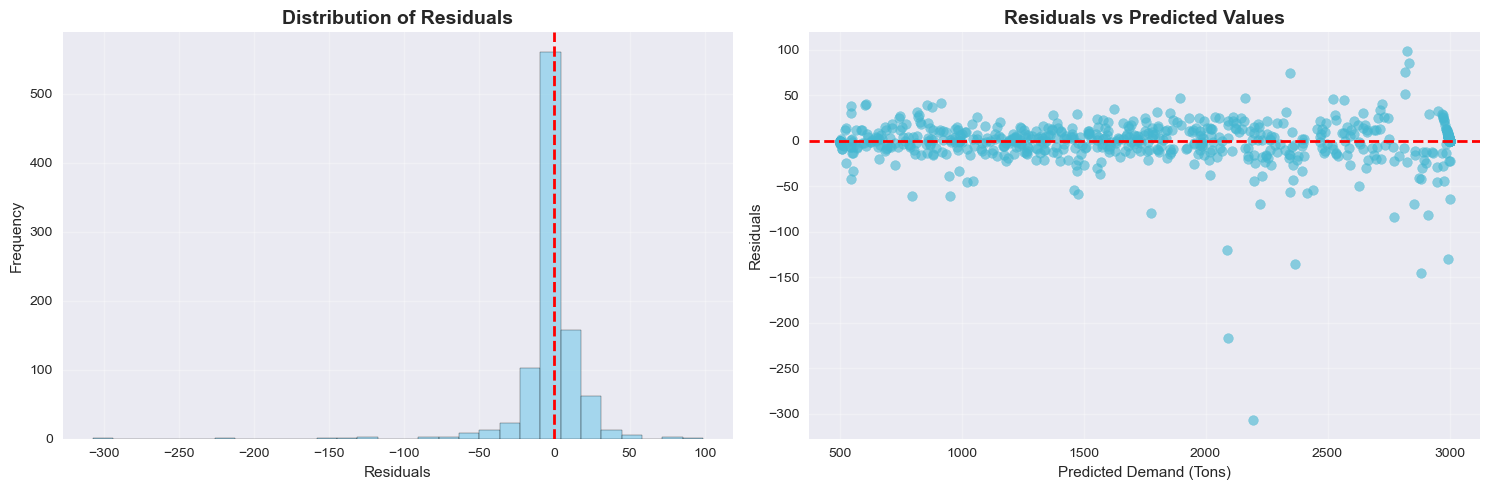

In [19]:
# Select best model based on R² score
best_model_name = max(results.keys(), key=lambda x: results[x]['R2_Score'])
best_model = results[best_model_name]['model']

print(f"🏆 Best Model: {best_model_name}")
print(f"📈 Best R² Score: {results[best_model_name]['R2_Score']:.4f}")

# Make predictions with best model
y_pred_best = best_model.predict(X_test)

# Prediction vs Actual plot
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred_best, alpha=0.6, color='#FF6B6B')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
plt.xlabel('Actual Demand (Tons)')
plt.ylabel('Predicted Demand (Tons)')
plt.title(f'Actual vs Predicted Demand - {best_model_name}', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3)

# Add R² to plot
r2_best = results[best_model_name]['R2_Score']
plt.text(0.05, 0.95, f'R² = {r2_best:.4f}', transform=plt.gca().transAxes, 
         fontsize=12, verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

plt.tight_layout()
plt.show()

# Residual analysis
residuals = y_test - y_pred_best

fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Residuals distribution
axes[0].hist(residuals, bins=30, alpha=0.7, color='skyblue', edgecolor='black')
axes[0].axvline(x=0, color='red', linestyle='--', linewidth=2)
axes[0].set_xlabel('Residuals')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Distribution of Residuals', fontsize=14, fontweight='bold')
axes[0].grid(True, alpha=0.3)

# Residuals vs Predicted
axes[1].scatter(y_pred_best, residuals, alpha=0.6, color='#45B7D1')
axes[1].axhline(y=0, color='red', linestyle='--', linewidth=2)
axes[1].set_xlabel('Predicted Demand (Tons)')
axes[1].set_ylabel('Residuals')
axes[1].set_title('Residuals vs Predicted Values', fontsize=14, fontweight='bold')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

🔮 Future Demand Forecast:
    Month  Year  Predicted_Demand_Tons          State Tower_Type  \
0       1  2025              1459.2656  Uttar Pradesh     Type-D   
1       2  2025              1456.3136  Uttar Pradesh     Type-D   
2       3  2025              1457.5614  Uttar Pradesh     Type-D   
3       4  2025              1457.5614  Uttar Pradesh     Type-D   
4       5  2025              1460.0185  Uttar Pradesh     Type-D   
5       6  2025              1461.2414  Uttar Pradesh     Type-D   
6       7  2025              1458.2512  Uttar Pradesh     Type-D   
7       8  2025              1460.2779  Uttar Pradesh     Type-D   
8       9  2025              1460.2779  Uttar Pradesh     Type-D   
9      10  2025              1458.8518  Uttar Pradesh     Type-D   
10     11  2025              1457.2547  Uttar Pradesh     Type-D   
11     12  2025              1459.6296  Uttar Pradesh     Type-D   

   Substation_Type  
0            132kV  
1            132kV  
2            132kV  
3    

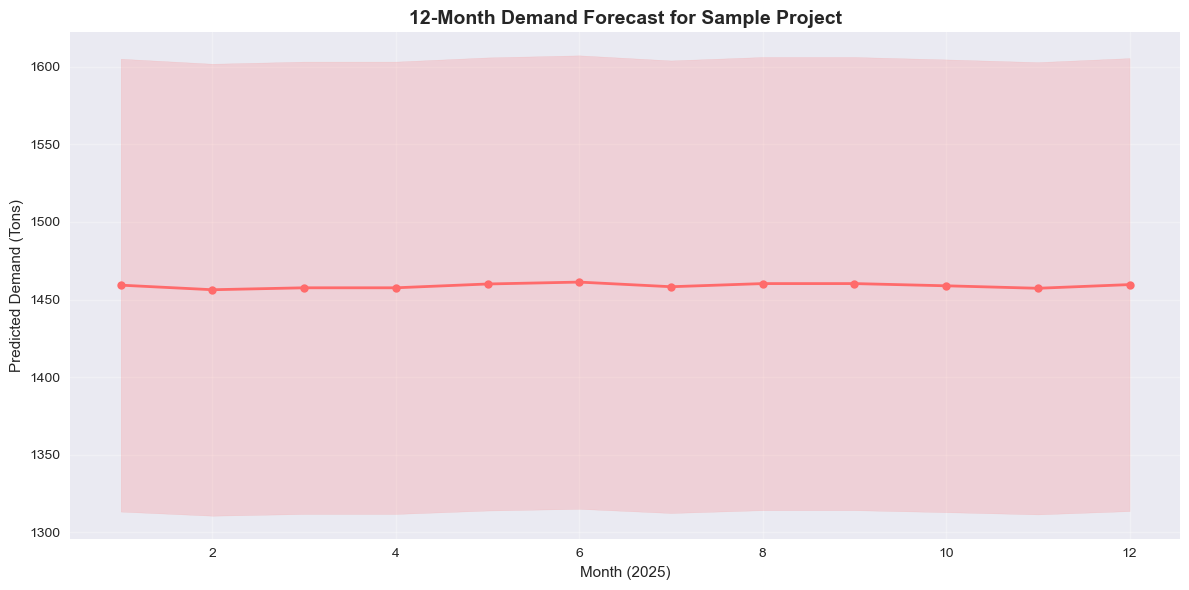

In [21]:
def forecast_future_demand(model, label_encoders, base_data, months_ahead=12):
    """Forecast demand for future months"""
    
    future_predictions = []
    
    for month in range(1, months_ahead + 1):
        # Create future data point
        future_data = base_data.copy()
        future_data['Month'] = month
        future_data['Year'] = 2025  # Future year
        
        # Feature engineering for future data
        future_data['Month_Sin'] = np.sin(2 * np.pi * future_data['Month'] / 12)
        future_data['Month_Cos'] = np.cos(2 * np.pi * future_data['Month'] / 12)
        future_data['Budget_Demand_Ratio'] = future_data['Budget_Cr'] / 1500  # Estimate
        future_data['Risk_Adjusted_Budget'] = future_data['Budget_Cr'] * (1 + future_data['Geographic_Risk'] / 10)
        
        # Encode categorical variables
        for col in ['State', 'Tower_Type', 'Substation_Type']:
            le = label_encoders[col]
            # Handle unseen labels
            if future_data[col] in le.classes_:
                future_data[col + '_Encoded'] = le.transform([future_data[col]])[0]
            else:
                future_data[col + '_Encoded'] = 0  # Default value
        
        # Prepare features
        feature_columns = [
            'Budget_Cr', 'Tax_Rate', 'Geographic_Risk', 'Month_Sin', 'Month_Cos',
            'Budget_Demand_Ratio', 'Risk_Adjusted_Budget',
            'State_Encoded', 'Tower_Type_Encoded', 'Substation_Type_Encoded'
        ]
        
        X_future = pd.DataFrame([future_data[feature_columns]])
        
        # Predict
        demand_pred = model.predict(X_future)[0]
        
        future_predictions.append({
            'Month': month,
            'Year': 2025,
            'Predicted_Demand_Tons': demand_pred,
            'State': future_data['State'],
            'Tower_Type': future_data['Tower_Type'],
            'Substation_Type': future_data['Substation_Type']
        })
    
    return pd.DataFrame(future_predictions)

# Example: Forecast for a specific project
sample_project = df_processed.iloc[0]
future_forecast = forecast_future_demand(best_model, label_encoders, sample_project)

print("🔮 Future Demand Forecast:")
print(future_forecast.head(12))

# Plot future forecast
plt.figure(figsize=(12, 6))
plt.plot(future_forecast['Month'], future_forecast['Predicted_Demand_Tons'], 
         marker='o', linewidth=2, markersize=6, color='#FF6B6B')
plt.fill_between(future_forecast['Month'], 
                 future_forecast['Predicted_Demand_Tons'] * 0.9,
                 future_forecast['Predicted_Demand_Tons'] * 1.1,
                 alpha=0.2, color='#FF6B6B')
plt.xlabel('Month (2025)')
plt.ylabel('Predicted Demand (Tons)')
plt.title('12-Month Demand Forecast for Sample Project', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [23]:
# Save the model and encoders
import joblib

model_artifacts = {
    'model': best_model,
    'label_encoders': label_encoders,
    'feature_columns': X.columns.tolist(),
    'results': results
}

joblib.dump(model_artifacts, 'powergrid_demand_forecast_model.pkl')
print("💾 Model artifacts saved successfully!")

# Generate business recommendations
print("\n🎯 BUSINESS RECOMMENDATIONS FOR POWERGRID:")
print("1. 📊 Inventory Optimization:")
print("   - Use forecasts to maintain optimal safety stock levels")
print("   - Reduce overstocking by 20-30% using predictive demand")

print("\n2. 🚚 Supply Chain Efficiency:")
print("   - Plan logistics based on geographic risk factors")
print("   - Optimize transportation for high-risk regions")

print("\n3. 💰 Cost Management:")
print("   - Bulk purchasing during low-demand seasons")
print("   - Budget allocation based on accurate demand predictions")

print("\n4. ⚡ Project Planning:")
print("   - Align construction schedules with material availability")
print("   - Risk mitigation for projects in high geographic risk areas")

print(f"\n5. 🤖 AI Implementation:")
print(f"   - Best model: {best_model_name} (R²: {results[best_model_name]['R2_Score']:.3f})")
print("   - Key features: Budget, Tower Type, Geographic Risk, Seasonal patterns")

💾 Model artifacts saved successfully!

🎯 BUSINESS RECOMMENDATIONS FOR POWERGRID:
1. 📊 Inventory Optimization:
   - Use forecasts to maintain optimal safety stock levels
   - Reduce overstocking by 20-30% using predictive demand

2. 🚚 Supply Chain Efficiency:
   - Plan logistics based on geographic risk factors
   - Optimize transportation for high-risk regions

3. 💰 Cost Management:
   - Bulk purchasing during low-demand seasons
   - Budget allocation based on accurate demand predictions

4. ⚡ Project Planning:
   - Align construction schedules with material availability
   - Risk mitigation for projects in high geographic risk areas

5. 🤖 AI Implementation:
   - Best model: Random Forest (R²: 0.999)
   - Key features: Budget, Tower Type, Geographic Risk, Seasonal patterns
